In [1]:
pip install xgboost scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 2.8 MB/s eta 0:00:0000:0100:03
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install "xgboost[spark]" pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 480.4 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# XGBoost model

In [2]:
from pyspark.sql import SparkSession
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
# ✅ 2️⃣ Start Spark Session
spark = (
    SparkSession.builder
    .appName("XGBoost_SparkApp")
    .master("local[*]")  # use all cores
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

# Pipeline building

In [3]:
pip show xgboost

Name: xgboost
Version: 3.0.5
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip show pyspark

Name: pyspark
Version: 3.5.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/spark/python
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
from xgboost.spark import SparkXGBClassifier
print("✅ Spark XGBoost import successful!")

✅ Spark XGBoost import successful!


In [8]:
#!/usr/bin/env python3
# train_and_eval_ddos_pipeline.py

import os
import json
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier  # XGBoost 3.x Spark API

# ============================================================
# CONFIG
# ============================================================
DATA_PATH = "/home/jovyan/work/merged_dataset.csv"
OUTPUT_DIR = "/home/jovyan/work/pipeline_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PIPELINE_SAVE_PATH = os.path.join(OUTPUT_DIR, "ddos_xgb_pipeline")
METADATA_SAVE_PATH = os.path.join(OUTPUT_DIR, "pipeline_metadata.json")
PREDICTIONS_SAVE_PATH = os.path.join(OUTPUT_DIR, "predictions_with_metadata.csv")

# ============================================================
# SPARK SESSION
# ============================================================
spark = (
    SparkSession.builder
    .appName("DDoS_Pipeline_Final_Auto")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

# ============================================================
# COLUMN NORMALIZATION MAP
# ============================================================
col_name_map = {
    "Flow Duration": "flow_duration",
    "FlowDuration": "flow_duration",
    "Total Fwd Packets": "total_fwd_packets",
    "Total Bwd Packets": "total_bwd_packets",
    "Total Length of Fwd Packets": "total_len_fwd_packets",
    "Total Length of Bwd Packets": "total_len_bwd_packets",
    "Fwd Packet Length Max": "fwd_pkt_len_max",
    "Bwd Packet Length Max": "bwd_pkt_len_max",
    "Fwd Packet Length Min": "fwd_pkt_len_min",
    "Bwd Packet Length Min": "bwd_pkt_len_min",
    "Flow Bytes/s": "flow_bytes_per_s",
    "Flow Packets/s": "flow_pkts_per_s",
    "Flow IAT Mean": "flow_iat_mean",
    "Flow IAT Std": "flow_iat_std",
    "Flow IAT Max": "flow_iat_max",
    "Flow IAT Min": "flow_iat_min",
    "Fwd IAT Mean": "fwd_iat_mean",
    "Bwd IAT Mean": "bwd_iat_mean",
    "Fwd PSH Flags": "fwd_psh_flags",
    "Bwd PSH Flags": "bwd_psh_flags",
    "Fwd URG Flags": "fwd_urg_flags",
    "Bwd URG Flags": "bwd_urg_flags",
    "FIN Flag Count": "fin_flag_cnt",
    "SYN Flag Count": "syn_flag_cnt",
    "RST Flag Count": "rst_flag_cnt",
    "ACK Flag Count": "ack_flag_cnt",
    "ECE Flag Count": "ece_flag_cnt",
    "Down/Up Ratio": "down_up_ratio",
    "Average Packet Size": "avg_pkt_size",
    "Avg Fwd Segment Size": "avg_fwd_seg_size",
    "Avg Bwd Segment Size": "avg_bwd_seg_size",
    "Fwd Header Length": "fwd_header_len",
    "Bwd Header Length": "bwd_header_len",
    "Fwd Packets/s": "fwd_pkts_per_s",
    "Bwd Packets/s": "bwd_pkts_per_s",
    "Label": "Label",
    "label": "Label"
}

# ============================================================
# FEATURE LIST (selected)
# ============================================================
feature_cols = [
    "flow_duration", "total_fwd_packets", "total_bwd_packets",
    "total_len_fwd_packets", "total_len_bwd_packets",
    "fwd_pkt_len_max", "bwd_pkt_len_max", "fwd_pkt_len_min", "bwd_pkt_len_min",
    "flow_bytes_per_s", "flow_pkts_per_s", "flow_iat_mean", "flow_iat_std",
    "flow_iat_max", "flow_iat_min", "fwd_iat_mean", "bwd_iat_mean",
    "fwd_psh_flags", "bwd_psh_flags", "fwd_urg_flags", "bwd_urg_flags",
    "fin_flag_cnt", "syn_flag_cnt", "rst_flag_cnt", "ack_flag_cnt", "ece_flag_cnt",
    "down_up_ratio", "avg_pkt_size", "avg_fwd_seg_size", "avg_bwd_seg_size",
    "fwd_header_len", "bwd_header_len", "fwd_pkts_per_s", "bwd_pkts_per_s"
]
expected_columns = feature_cols + ["Label"]

# ============================================================
# 1. LOAD DATA (OUTSIDE PIPELINE)
# ============================================================
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# Normalize column names (OUTSIDE pipeline)
for src, canon in col_name_map.items():
    if src in df.columns and src != canon:
        df = df.withColumnRenamed(src, canon)

# Add missing expected columns (OUTSIDE pipeline)
for col in expected_columns:
    if col not in df.columns:
        df = df.withColumn(col, F.lit(0.0))

# Cast numeric features to Double and handle missing values (OUTSIDE pipeline)
for c in feature_cols:
    df = df.withColumn(c, F.col(c).cast(DoubleType()))
df = df.fillna(0).dropDuplicates()

# Keep original Label column (string). We will index it inside pipeline.
# If Label missing, fill with 'Unknown'
df = df.withColumn("Label", F.coalesce(F.col("Label"), F.lit("Unknown")))

# ============================================================
# 2. CALCULATE CLASS WEIGHTS (OUTSIDE PIPELINE)
# ============================================================
counts = df.groupBy("Label").count().collect()
total = sum(r["count"] for r in counts)
num_classes = len(counts) if len(counts) > 0 else 1
weight_map = {r["Label"]: float(total) / (num_classes * r["count"]) for r in counts}

# build classWeightCol using when/otherwise
wcol = F.lit(0.0)
for lbl, w in weight_map.items():
    wcol = F.when(F.col("Label") == lbl, F.lit(w)).otherwise(wcol)
df = df.withColumn("classWeightCol", wcol)

# ============================================================
# 3. PIPELINE (INSIDE): StringIndexer, Assembler, Scaler, XGBoost
# ============================================================
# StringIndexer to convert Label -> Label_index (kept inside pipeline)
label_indexer = StringIndexer(inputCol="Label", outputCol="Label_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_vec",
    handleInvalid="keep"
)

scaler = StandardScaler(
    inputCol="features_vec",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

# XGBoost classifier (uses Label_index and classWeightCol)
xgb = SparkXGBClassifier(
    features_col="scaled_features",
    label_col="Label_index",
    weight_col="classWeightCol",
    num_class=num_classes,
    num_workers=2,
    num_round=150,
    max_depth=8,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    probability_col="probability"  # ensures probability vector column is present
)

pipeline = Pipeline(stages=[label_indexer, assembler, scaler, xgb])

# ============================================================
# 4. TRAIN / TEST SPLIT (OUTSIDE PIPELINE)
# ============================================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ============================================================
# 5. TRAIN (fit pipeline)
# ============================================================
pipeline_model = pipeline.fit(train_df)
print("✅ Training complete!")

# ============================================================
# 6. PREDICT (pipeline.transform on test set)
# ============================================================
preds = pipeline_model.transform(test_df)
# preds currently includes:
# - original Label (string)
# - Label_index (numeric) (from StringIndexer inside pipeline)
# - features_vec, scaled_features
# - prediction (numeric) and probability (vector) from XGBoost

# ============================================================
# 7. CREATE prediction_label (decoded original label) using IndexToString
#    IndexToString needs the label-to-index mapping produced by fitted StringIndexerModel
# ============================================================
# Extract fitted StringIndexerModel to get labels
# Note: pipeline_model.stages[0] is the fitted StringIndexerModel (since we put it first)
fitted_label_indexer = pipeline_model.stages[0]
labels_list = fitted_label_indexer.labels  # array of original label strings in index order

# Use IndexToString transformer (no fitting required)
index_to_string = IndexToString(inputCol="prediction", outputCol="prediction_label", labels=labels_list)
preds = index_to_string.transform(preds)

# ============================================================
# 8. CREATE CLEAN probability_map COLUMN (sorted + 2 decimals)
# ============================================================

from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType, DoubleType

# Create probability → {label: prob} sorted DESC
def prob_to_map(prob_vec):
    try:
        pairs = [(labels_list[i], float(prob_vec[i])) for i in range(len(labels_list))]
        pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
        return {k: round(v, 2) for k, v in pairs_sorted}   # << 2 decimal places
    except:
        return {}

prob_to_map_udf = udf(prob_to_map, MapType(StringType(), DoubleType()))

# Stable row_id
preds = preds.withColumn("_tmp_id", F.monotonically_increasing_id())
w = Window.orderBy("_tmp_id")
preds = preds.withColumn("row_id", F.row_number().over(w)).drop("_tmp_id")

# Add probability_map
preds = preds.withColumn("probability_map", prob_to_map_udf(F.col("probability")))

# ============================================================
# 9. SELECT CLEAN FORENSIC OUTPUT COLUMNS
# ============================================================
final_df = preds.select(
    "row_id",
    "prediction_label",
    "probability_map"
)


# ============================================================
# 11. EVALUATION METRICS (OUTSIDE PIPELINE)
# ============================================================

metrics = {}

for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="Label_index", 
        predictionCol="prediction", 
        metricName=metric
    )
    try:
        val = evaluator.evaluate(preds)
        metrics[metric] = float(val)
    except Exception as e:
        metrics[metric] = None
        print(f"Warning: could not compute {metric}: {e}")

# ===== CLEAN FORMATTED OUTPUT =====
print("\n===== EVALUATION METRICS =====")
for k, v in metrics.items():
    if v is None:
        print(f"{k}: ERROR")
    else:
        print(f"{k}: {v:.4f}")   # 4 decimal places
print("================================\n")


# ============================================================
# 12. SAVE PIPELINE MODEL & METADATA (OUTSIDE PIPELINE)
#    Save pipeline_model (this includes StringIndexerModel, assembler, scaler, and trained XGBoost)
# ============================================================
# Save pipeline model
pipeline_model.write().overwrite().save(PIPELINE_SAVE_PATH)
print("✅ Saved pipeline model to:", PIPELINE_SAVE_PATH)

# Save metadata including labels, feature columns, column map, class weights, metrics
metadata = {
    "feature_columns": feature_cols,
    "canonical_column_map": col_name_map,
    "label_mapping": labels_list,        # order corresponds to Label_index index
    "class_weights": weight_map,
    "metrics": metrics
}
with open(METADATA_SAVE_PATH, "w") as f:
    json.dump(metadata, f, indent=2)
print("✅ Saved pipeline metadata to:", METADATA_SAVE_PATH)

# ============================================================
# 13. SAVE & PRINT PREDICTIONS (OUTSIDE PIPELINE)
#    Save CSV and print a preview (both)
# ============================================================
# Save to CSV (coalesce to 1 file for convenience; remove if large-scale)
#final_df.coalesce(1).write.mode("overwrite").option("header", True).csv(PREDICTIONS_SAVE_PATH)
#print("✅ Saved predictions to CSV (folder):", PREDICTIONS_SAVE_PATH)

# Print sample preview (show first 5 rows)
print("\n===== PREDICTIONS SAMPLE =====")
final_df.show(20, truncate=False)
print("==============================\n")

# Also write a JSON-lines version for easier ingestion if needed
PREDICTIONS_JSONL = os.path.join(OUTPUT_DIR, "predictions_with_metadata.jsonl")
final_df.write.mode("overwrite").json(PREDICTIONS_JSONL)
print("✅ Also saved predictions as JSON (folder):", PREDICTIONS_JSONL)

# ============================================================
# 14. OPTIONAL: Save human-readable CSV file path - find the actual part file
#    (Spark CSV output writes part files inside the target folder).
#    We'll attempt to locate the actual CSV file and rename it to a stable path.
# ============================================================


2025-11-15 09:49:59,389 INFO XGBoost-PySpark: _fit Running xgboost-3.0.5 on 2 workers with
	booster params: {'objective': 'multi:softprob', 'colsample_bytree': 0.8, 'device': 'cpu', 'max_depth': 8, 'subsample': 0.8, 'tree_method': 'hist', 'num_class': 4, 'num_round': 150, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-15 09:53:22,795 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ Training complete!

===== EVALUATION METRICS =====
accuracy: 0.8915
f1: 0.8971
weightedPrecision: 0.9063
weightedRecall: 0.8915

✅ Saved pipeline model to: /home/jovyan/work/pipeline_output/ddos_xgb_pipeline
✅ Saved pipeline metadata to: /home/jovyan/work/pipeline_output/pipeline_metadata.json

===== PREDICTIONS SAMPLE =====
+------+------------------+-------------------------------------------------------------------------------------------+
|row_id|prediction_label  |probability_map                                                                            |
+------+------------------+-------------------------------------------------------------------------------------------+
|1     |ICMP_Flood        |{ACK_fragmentation -> 0.02, ICMP_fragmentation -> 0.36, ICMP_Flood -> 0.5, Benign -> 0.12} |
|2     |ICMP_Flood        |{ACK_fragmentation -> 0.03, ICMP_fragmentation -> 0.39, ICMP_Flood -> 0.46, Benign -> 0.13}|
|3     |ICMP_fragmentation|{ACK_fragmentation -> 0.03, ICMP_fragmentati

In [3]:
import json

path = "/home/jovyan/work/pipeline_output/label_mapping.json"
with open(path, "r") as f:
    data = json.load(f)

print("🔥 LABEL ORDER USED BY YOUR MODEL:")
for i, name in enumerate(data["labels"]):
    print(f"{i} → {name}")


🔥 LABEL ORDER USED BY YOUR MODEL:
0 → ACK_fragmentation
1 → Benign
2 → ICMP_fragmentation
3 → ICMP_Flood


In [18]:
# ================================
# Forensic + Temporal Analysis (cleaned + robust)
# ================================
import os
import json
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType, MapType
import matplotlib.pyplot as plt
import pandas as pd

OUTPUT_DIR = "/home/jovyan/work/pipeline_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Preconditions:
# preds DataFrame must exist in this Python scope (from pipeline run).
# It should include:
#  - prediction_label (string)
#  - probability (vector) OR probability_map (map<string,double>)
#  - original flow columns (Flow ID, Src IP, Src Port, Dst IP, Dst Port, Protocol, Timestamp)
# -------------------------

# -------------------------
# Smart join logic: ensure preds has raw flow columns (load original if necessary)
# -------------------------
required_cols = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol", "Timestamp"]
has_all_raw = all(col in preds.columns for col in required_cols)

if not has_all_raw:
    print("🔍 preds missing raw columns -> loading original dataset for join.")
    orig = spark.read.csv("/home/jovyan/work/merged_dataset.csv", header=True, inferSchema=True)

    orig_has_id = "row_id" in orig.columns
    preds_has_id = "row_id" in preds.columns

    # Case handling for row_id presence (create when missing)
    if not orig_has_id and not preds_has_id:
        print("⚠️ Neither preds nor original has row_id → creating row_id on both.")
        orig = orig.withColumn("row_id", F.monotonically_increasing_id())
        preds = preds.withColumn("row_id", F.monotonically_increasing_id())
    elif orig_has_id and not preds_has_id:
        print("⚠️ preds missing row_id → creating row_id on preds.")
        preds = preds.withColumn("row_id", F.monotonically_increasing_id())
    elif preds_has_id and not orig_has_id:
        print("⚠️ original missing row_id → creating row_id on original.")
        orig = orig.withColumn("row_id", F.monotonically_increasing_id())
    else:
        print("✅ Both preds and original already have row_id → using it.")

    # left join so preds rows are preserved
    preds = preds.join(orig, on="row_id", how="left")
else:
    print("✅ preds already contains all original flow columns — no join needed.")

# ============================================================
# 1) FORENSIC ANALYSIS
# ============================================================

BENIGN_LABELS = set(["Benign", "benign", "BENIGN"])

# ensure prediction_label exists (if not, try to create from prediction + label mapping)
if "prediction_label" not in preds.columns:
    # try to build it using labels_list from scope or metadata
    try:
        labels_list  # noqa: F821
    except NameError:
        # attempt to load from saved metadata
        meta_path = os.path.join(OUTPUT_DIR, "pipeline_metadata.json")
        labels_list = None
        if os.path.exists(meta_path):
            try:
                with open(meta_path, "r") as mf:
                    meta = json.load(mf)
                    labels_list = meta.get("label_mapping") or meta.get("labels") or meta.get("label_list")
            except Exception:
                labels_list = None

    if labels_list:
        # create an index->string mapping using IndexToString would be nicer, but quick fallback:
        # map numeric prediction -> string via udf using labels_list
        def idx_to_label(idx):
            try:
                return labels_list[int(idx)]
            except Exception:
                return None
        idx_to_label_udf = F.udf(lambda i: idx_to_label(i), StringType())
        preds = preds.withColumn("prediction_label", idx_to_label_udf(F.col("prediction")))

# Mark attack rows
if "prediction_label" in preds.columns:
    preds = preds.withColumn("is_attack", ~F.col("prediction_label").isin(list(BENIGN_LABELS)))
else:
    # fallback: if no prediction_label, consider numeric prediction != benign_index as attack (not ideal)
    preds = preds.withColumn("is_attack", F.lit(False))
    print("⚠️ prediction_label missing — 'is_attack' set to False for all rows (please check).")

attacks = preds.filter(F.col("is_attack") == True)

# ------------------------------------------------------------
# Build probability_map if missing
# ------------------------------------------------------------
if "probability_map" not in preds.columns:
    # Try to get labels_list from scope or metadata
    try:
        labels_list  # noqa: F821
    except NameError:
        # load from pipeline metadata if available
        meta_path = os.path.join(OUTPUT_DIR, "pipeline_metadata.json")
        labels_list = None
        if os.path.exists(meta_path):
            try:
                with open(meta_path, "r") as mf:
                    meta = json.load(mf)
                    labels_list = meta.get("label_mapping") or meta.get("labels") or meta.get("label_list")
            except Exception:
                labels_list = None

    if labels_list:
        # udf to convert probability vector -> python dict {label: float}
        def vec_to_map(v):
            try:
                return {labels_list[i]: float(v[i]) for i in range(len(labels_list))}
            except Exception:
                return {}
        prob_map_udf = F.udf(lambda vv: vec_to_map(vv), MapType(StringType(), DoubleType()))
        preds = preds.withColumn("probability_map", prob_map_udf(F.col("probability")))
        attacks = preds.filter(F.col("is_attack") == True)
    else:
        # can't build map; create empty map column to keep code paths consistent
        empty_map_udf = F.udf(lambda v: {}, MapType(StringType(), DoubleType()))
        preds = preds.withColumn("probability_map", empty_map_udf(F.lit(None)))
        attacks = preds.filter(F.col("is_attack") == True)

# ------------------------------------------------------------
# Extract top probability for each row (as double)
# ------------------------------------------------------------
def extract_top_prob(m):
    try:
        if not m:
            return 0.0
        items = list(m.items())
        items.sort(key=lambda x: x[1], reverse=True)
        return float(items[0][1])
    except Exception:
        return 0.0

extract_top_prob_udf = F.udf(lambda m: extract_top_prob(m), DoubleType())
attacks = attacks.withColumn("top_probability", extract_top_prob_udf(F.col("probability_map")))

# ============================================================
# Forensic report: choose columns (only present columns will be kept)
# ============================================================
forensic_cols = [
    "Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol", "Timestamp",
    "prediction_label", "top_probability", "probability_map"
]
forensic_cols_existing = [c for c in forensic_cols if c in attacks.columns]
forensic_report = attacks.select(*forensic_cols_existing)

# Output paths
FORENSIC_JSONL = os.path.join(OUTPUT_DIR, "forensic_report_json")
FORENSIC_CSV = os.path.join(OUTPUT_DIR, "forensic_report_csv")

# Save JSONL (map types supported)
forensic_report.write.mode("overwrite").json(FORENSIC_JSONL)
print("✅ Forensic report saved (JSON folder):", FORENSIC_JSONL)

# CSV can't handle MapType -> drop/flatten probability_map for CSV
csv_safe = forensic_report
if "probability_map" in csv_safe.columns:
    # convert probability_map to JSON string column for CSV
    csv_safe = csv_safe.withColumn("probability_map_json", F.to_json(F.col("probability_map"))).drop("probability_map")

csv_safe.coalesce(1).write.mode("overwrite").option("header", True).csv(FORENSIC_CSV)
print("✅ Forensic report saved (CSV folder):", FORENSIC_CSV)

# ============================================================
# Temporal analysis (clean + fixed)
# ============================================================
if "Timestamp" not in preds.columns:
    print("⚠️ No 'Timestamp' column found. Temporal analysis skipped.")
else:
    # 1) Parse timestamps using the known format 'dd/MM/yyyy hh:mm:ss a'
    preds = preds.withColumn("ts", F.to_timestamp(F.col("Timestamp"), "dd/MM/yyyy hh:mm:ss a"))

    # 2) If many NULLs remain, fallback to auto parse of cleaned string
    preds = preds.withColumn(
        "ts",
        F.when(F.col("ts").isNull(), F.to_timestamp(F.regexp_replace(F.col("Timestamp").cast(StringType()), r" UTC$", ""))).otherwise(F.col("ts"))
    )

    # 3) Time features
    preds = preds.withColumn("hour", F.hour("ts")) \
                 .withColumn("day_of_week", F.date_format("ts", "E")) \
                 .withColumn("date", F.to_date("ts")) \
                 .withColumn("day_of_week_num", F.date_format("ts", "u").cast("int")) \
                 .withColumn("is_weekend", F.col("day_of_week_num").isin(6, 7))

    preds = preds.withColumn(
        "time_of_day",
        F.when((F.col("hour") >= 0) & (F.col("hour") < 6), F.lit("Night"))
         .when((F.col("hour") >= 6) & (F.col("hour") < 12), F.lit("Morning"))
         .when((F.col("hour") >= 12) & (F.col("hour") < 18), F.lit("Afternoon"))
         .otherwise(F.lit("Evening"))
    )

    # focus only on attack rows
    temporal_attacks = preds.filter(F.col("is_attack") == True)

    # Aggregations
    attacks_by_hour = temporal_attacks.groupBy("hour").count().orderBy("hour")
    attacks_by_hour_df = attacks_by_hour.toPandas()
    # ensure hour is numeric and sorted
    if 'hour' in attacks_by_hour_df.columns:
        attacks_by_hour_df['hour'] = pd.to_numeric(attacks_by_hour_df['hour'], errors='coerce').fillna(-1).astype(int)
        attacks_by_hour_df = attacks_by_hour_df.sort_values('hour')

    attacks_by_day = temporal_attacks.groupBy("day_of_week").count().toPandas()
    # handle unknown weekday names gracefully and sort in weekday order
    weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    attacks_by_day['day_num'] = attacks_by_day['day_of_week'].apply(lambda x: weekday_order.index(x) + 1 if x in weekday_order else 99)
    attacks_by_day = attacks_by_day.sort_values('day_num')

    attacks_by_tod = temporal_attacks.groupBy("time_of_day").count().toPandas()
    # ensure consistent order for time_of_day
    tod_order = ["Night", "Morning", "Afternoon", "Evening"]
    attacks_by_tod['tod_num'] = attacks_by_tod['time_of_day'].apply(lambda x: tod_order.index(x) if x in tod_order else 99)
    attacks_by_tod = attacks_by_tod.sort_values('tod_num')

    # Save CSVs
    attacks_by_hour_df.to_csv(os.path.join(OUTPUT_DIR, "attacks_by_hour.csv"), index=False)
    attacks_by_day.to_csv(os.path.join(OUTPUT_DIR, "attacks_by_day.csv"), index=False)
    attacks_by_tod.to_csv(os.path.join(OUTPUT_DIR, "attacks_by_time_of_day.csv"), index=False)

    # Plot: Peak Attack Hours
    plt.figure(figsize=(10, 4))
    plt.bar(attacks_by_hour_df['hour'], attacks_by_hour_df['count'])
    plt.xlabel("Hour of day (0-23)")
    plt.ylabel("Attack count")
    plt.title("Peak Attack Hours")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    path_hour_plot = os.path.join(OUTPUT_DIR, "peak_attack_hours.png")
    plt.savefig(path_hour_plot)
    plt.close()

    # Plot: Attacks by Day of Week
    plt.figure(figsize=(8, 4))
    plt.bar(attacks_by_day['day_num'], attacks_by_day['count'])
    plt.xlabel("Day of week (1=Mon ... 7=Sun)")
    plt.ylabel("Attack count")
    plt.title("Attacks by Day of Week")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    path_day_plot = os.path.join(OUTPUT_DIR, "attacks_by_day.png")
    plt.savefig(path_day_plot)
    plt.close()

    # Plot: Attacks by Time of Day
    plt.figure(figsize=(6, 4))
    plt.bar(attacks_by_tod['time_of_day'], attacks_by_tod['count'])
    plt.xlabel("Time of day")
    plt.ylabel("Attack count")
    plt.title("Attacks by Time of Day")
    plt.tight_layout()
    path_tod_plot = os.path.join(OUTPUT_DIR, "attacks_by_time_of_day.png")
    plt.savefig(path_tod_plot)
    plt.close()

    # Print saved locations
    print("✅ Clean temporal plots & CSVs saved. Locations:")
    print(" - attacks_by_hour.csv :", os.path.join(OUTPUT_DIR, "attacks_by_hour.csv"))
    print(" - attacks_by_day.csv  :", os.path.join(OUTPUT_DIR, "attacks_by_day.csv"))
    print(" - attacks_by_tod.csv  :", os.path.join(OUTPUT_DIR, "attacks_by_time_of_day.csv"))
    print(" - peak_attack_hours   :", path_hour_plot)
    print(" - attacks_by_day.png  :", path_day_plot)
    print(" - attacks_by_tod.png  :", path_tod_plot)

print("✅ Forensic + Temporal analysis finished. Check:", OUTPUT_DIR)


✅ preds already contains all original flow columns — no join needed.
✅ Forensic report saved (JSON folder): /home/jovyan/work/pipeline_output/forensic_report_json
✅ Forensic report saved (CSV folder): /home/jovyan/work/pipeline_output/forensic_report_csv
✅ Clean temporal plots & CSVs saved. Locations:
 - attacks_by_hour.csv : /home/jovyan/work/pipeline_output/attacks_by_hour.csv
 - attacks_by_day.csv  : /home/jovyan/work/pipeline_output/attacks_by_day.csv
 - attacks_by_tod.csv  : /home/jovyan/work/pipeline_output/attacks_by_time_of_day.csv
 - peak_attack_hours   : /home/jovyan/work/pipeline_output/peak_attack_hours.png
 - attacks_by_day.png  : /home/jovyan/work/pipeline_output/attacks_by_day.png
 - attacks_by_tod.png  : /home/jovyan/work/pipeline_output/attacks_by_time_of_day.png
✅ Forensic + Temporal analysis finished. Check: /home/jovyan/work/pipeline_output


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract trained XGBoost model from pipeline
xgb_model = pipeline_model.stages[-1]   # This is SparkXGBClassifierModel

# Extract Booster from Spark XGBoost
booster = xgb_model.get_booster()

# Get feature importance as dictionary
importance_dict = booster.get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Top Features)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


NameError: name 'pipeline_model' is not defined

In [3]:
import os

model_path = "/home/jovyan/work/pipeline_output/ddos_xgb_pipeline"

print("Exists:", os.path.exists(model_path))
print("Is directory:", os.path.isdir(model_path))


Exists: True
Is directory: True


In [5]:
from pyspark.ml.pipeline import PipelineModel

model_path = "/home/jovyan/work/pipeline_output/ddos_xgb_pipeline"
pipeline_model = PipelineModel.load(model_path)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [6]:
# Extract trained XGBoost model
xgb_model = pipeline_model.stages[-1]   # Last stage

# Extract booster
booster = xgb_model.get_booster()

# Get importance scores
importance_dict = booster.get_score(importance_type='weight')

importance_dict

{'f0': 5057.0,
 'f5': 6202.0,
 'f6': 3060.0,
 'f7': 2586.0,
 'f8': 2272.0,
 'f11': 3393.0,
 'f12': 3343.0,
 'f13': 3434.0,
 'f14': 5292.0,
 'f15': 3001.0,
 'f16': 1923.0,
 'f17': 403.0,
 'f21': 1098.0,
 'f22': 828.0,
 'f23': 654.0,
 'f24': 1660.0,
 'f25': 242.0,
 'f26': 528.0,
 'f27': 4718.0,
 'f30': 2916.0,
 'f31': 1823.0,
 'f32': 2719.0,
 'f33': 2641.0}

In [7]:
from pyspark.ml.pipeline import PipelineModel
pipeline_model = PipelineModel.load("/home/jovyan/work/pipeline_output/ddos_xgb_pipeline")

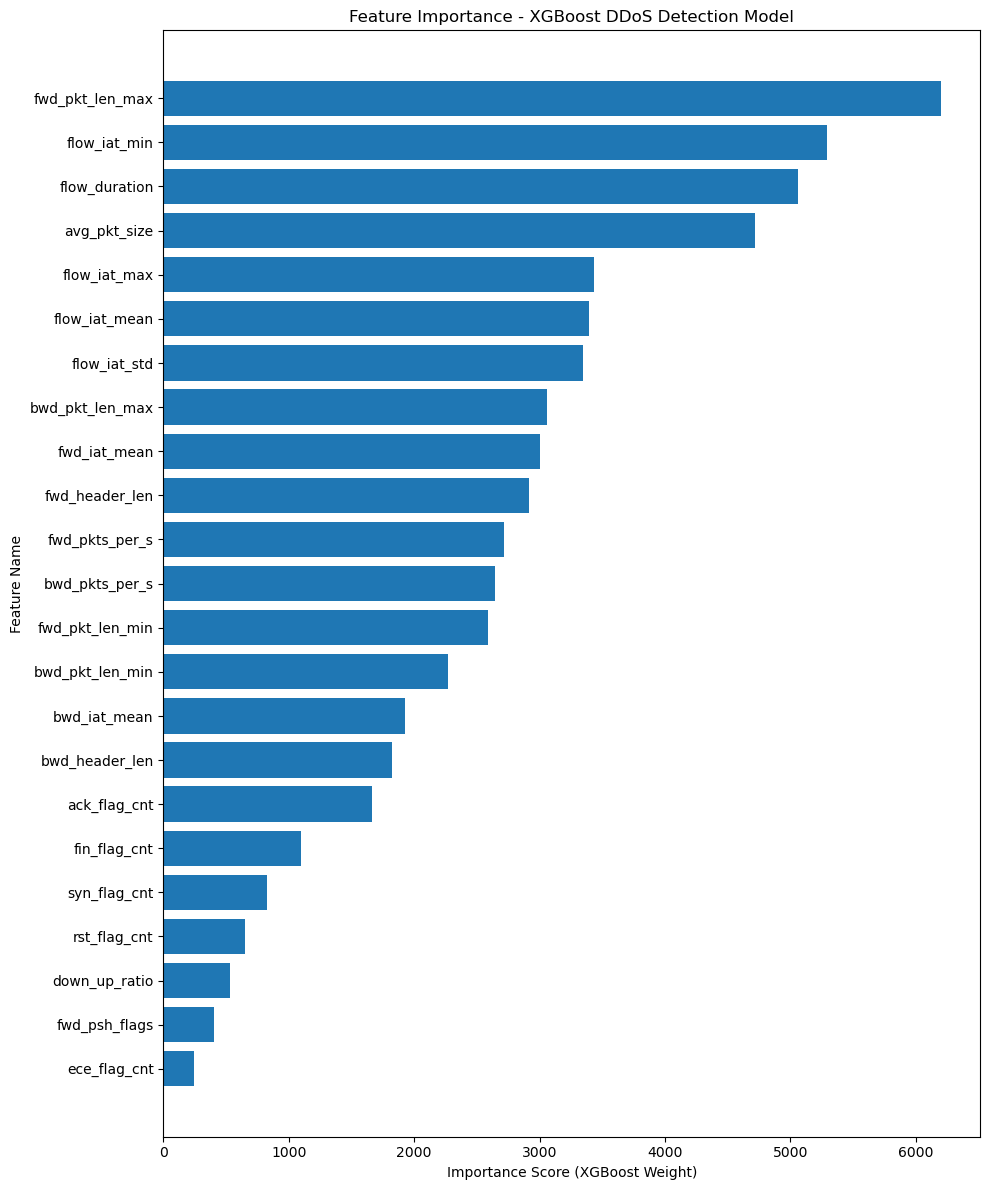

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.pipeline import PipelineModel

# ------------------------------------------------------------
# 1. Load your Spark Pipeline Model
# ------------------------------------------------------------
model_path = "/home/jovyan/work/pipeline_output/ddos_xgb_pipeline"
pipeline_model = PipelineModel.load(model_path)

# ------------------------------------------------------------
# 2. Extract the XGBoost model (last stage in pipeline)
# ------------------------------------------------------------
xgb_model = pipeline_model.stages[-1]   # SparkXGBClassifierModel
booster = xgb_model.get_booster()

# ------------------------------------------------------------
# 3. Load metadata (feature names)
# ------------------------------------------------------------
import json
metadata_path = "/home/jovyan/work/pipeline_output/pipeline_metadata.json"
with open(metadata_path, "r") as f:
    metadata = json.load(f)

feature_cols = metadata["feature_columns"]   # actual feature names

# ------------------------------------------------------------
# 4. Get importance scores from XGBoost booster
# ------------------------------------------------------------
importance_dict = booster.get_score(importance_type='weight')

# XGBoost returns features like "f0", "f1", etc. -> map them
mapped_importance = []
for key, value in importance_dict.items():
    idx = int(key[1:])  # remove "f"
    if idx < len(feature_cols):
        mapped_importance.append((feature_cols[idx], value))

# Convert to DataFrame
importance_df = pd.DataFrame(mapped_importance, columns=["Feature", "Importance"])

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# ------------------------------------------------------------
# 5. Plot the Feature Importance
# ------------------------------------------------------------
plt.figure(figsize=(10, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score (XGBoost Weight)")
plt.ylabel("Feature Name")
plt.title("Feature Importance - XGBoost DDoS Detection Model")
plt.tight_layout()
plt.show()
